# Introduction

Hello, I'm **Wesley**, nice to meet you! 👋

Recently, someone asked me if you can classify dog images into their respective dog breeds instead just differentiating from cats vs dogs like my [last notebook](https://www.kaggle.com/code/wesleyacheng/cat-vs-dog-image-classification-with-cnns). I say **YES**!

Due to the complexity of the problem, we will be using the most advanced computer vision architecture released in the [2020 Google paper](https://arxiv.org/pdf/2010.11929v2.pdf), the [**Vision Transformer**](https://paperswithcode.com/methods/category/vision-transformer).

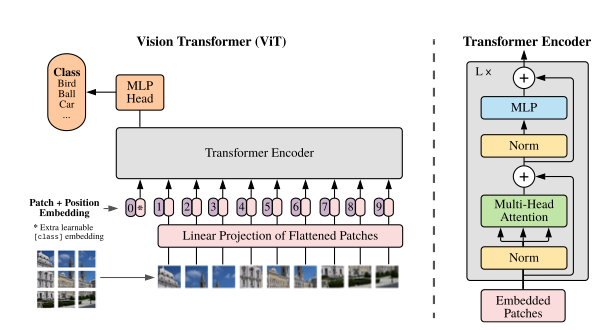

The difference between the **Vision Transformer** and the traditional **Convolutional Neural Network (CNN)** is how it treats an image. In **Vision Transformers**, we take the input as a patch of the original image, say 16 x 16, and feed in into the Transformer as a sequence with positional embeddings and self-attention, while in the **CNN**, we use the same patch of original image as an input, but use convolutions and pooling layers as inductive biases. What this means is that **Vision Transformer** can use it's judgement to attend any particular patch of the image in a *global* fashion using it's self-attention mechanism without having us to guide the neural network like a **CNN** with *local* centering/cropping/bounding box our images to help its convolutions. 

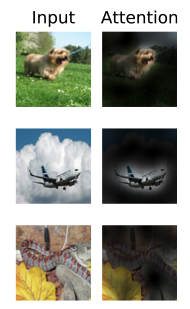

This allows the **Vision Transformer** architecture to be more flexible and scalable in nature, allowing us to create [foundation models](https://blogs.nvidia.com/blog/2023/03/13/what-are-foundation-models) in computer vision, similar to the NLP foundational models like [BERT](https://paperswithcode.com/method/bert) and [GPT](https://paperswithcode.com/method/gpt), with pre-training self-supervised/supervised on massive amount of image data that would generalize to different computer vision tasks such as *image classification, recognition, segmentation, etc.* This cross-pollination helps us move closer towards the goal of Artificial General Intelligence.

One thing about **Vision Transformers** are it has weaker inductive biases compared to **Convolutional Neural Networks** that enables it's scalability and flexibility. This feature/bug depending on who you ask will require most well-performing pre-trained models to require more data despite having less parameters compared to it's CNN counterparts.

Luckily, in this notebook, we will be using a **Vision Transformer** from [Google hosted at HuggingFace](https://huggingface.co/google/vit-base-patch16-224-in21k) pre-trained on the [ImageNet-21k dataset](https://paperswithcode.com/paper/imagenet-21k-pretraining-for-the-masses) (14 million images, 21k classes) with 16x16 patches, 224x224 resolution to bypass that data limitation. We will be fine-tuning this model to our "small" dog breeds dataset of around 20 thousand images from the [Stanford Dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) imported by Jessica Li into [Kaggle](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset) to classify dog images into 120 types of dog breeds!

If you would like to try this model without running the notebook, you can try it out at my [HuggingFace Inference Endpoint](https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit).

# Setup Python Libraries

In [1]:
%%bash
pip install numpy torch transformers~=4.28.0 evaluate tqdm sklearn --quiet
pip freeze | grep -E '^numpy|^torch|^transformers|^evaluate|^tqdm|^sklearn'

evaluate==0.4.0
numpy==1.23.5
sklearn==0.0.post5
sklearn-pandas==2.2.0
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=3a7abcaa5ae70fd4eb83c2cc43abc8ba94995316c6433e171d7454f107d41b58
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=83e258b68459f1ff64301c19c2fc791a692fd372271abeef8414854aafd03b06
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==0.11.4
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=110ca71f44e505c040ea2f41dcaf798cd7de1b55cbedaa6687b9e21eec759844
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=3b0e4e01ab713c145b7e20684eb79f983e75c8c13034901f21e3e8a36a1b3292
tqdm==4.64.1
transformers==4.28.1


# Create Dog Breeds Dataset

In [2]:
import os

# get all the classes in the dataset
root_dirpath = '/kaggle/input/stanford-dogs-dataset'
annotations_dirpath = os.path.join(root_dirpath, 'annotations/Annotation')
images_dirpath = os.path.join(root_dirpath, 'images/Images')

ID2LABEL = {}
LABEL2ID = {}
for idx,image_filename in enumerate(os.listdir(images_dirpath)):
    label = image_filename.split('-')[1].lower()
    ID2LABEL[idx] = label
    LABEL2ID[label] = idx
    
NUM_LABELS = len(ID2LABEL)
print(f"NUM_LABELS: {NUM_LABELS}\n")

NUM_LABELS: 120



In [3]:
import PIL
from tqdm.notebook import tqdm

# let's import the dataset 
labels = []
images = []
for image_dirpath in tqdm(os.listdir(annotations_dirpath)):
    for image_filepath in os.listdir(os.path.join(annotations_dirpath, image_dirpath)): 
        annotation_filepath = os.path.join(annotations_dirpath, image_dirpath, image_filepath)
        image_filepath = os.path.join(images_dirpath, image_dirpath, image_filepath+'.jpg') 
        
        # getting label from directory name instead of xml for speed
        label = image_dirpath.split('-')[1].lower()
        # use lazy loading object to reduce ram usage
        with PIL.Image.open(image_filepath) as image:
            # only get images that are jpegs
            if isinstance(image, PIL.JpegImagePlugin.JpegImageFile):
                labels.append(label)
                images.append(image_filepath)
            
print(f"NUMBER OF LABELS: {len(labels)}")
print(f"NUMBER OF IMAGES: {len(images)}")

  0%|          | 0/120 [00:00<?, ?it/s]

NUMBER OF LABELS: 20579
NUMBER OF IMAGES: 20579


In [4]:
import datasets

# let's create the raw datasets of dog breeds
raw_datasets = datasets.Dataset.from_dict(
    mapping = {'image': images, 'labels': labels,},
    features = datasets.Features({
        'image': datasets.Image(),
        'labels': datasets.features.ClassLabel(names=list(LABEL2ID.keys())),
    })
)

raw_datasets

Dataset({
    features: ['image', 'labels'],
    num_rows: 20579
})

In [5]:
import random
import torch
import numpy as np

# we set the seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Exploratory Data Analysis

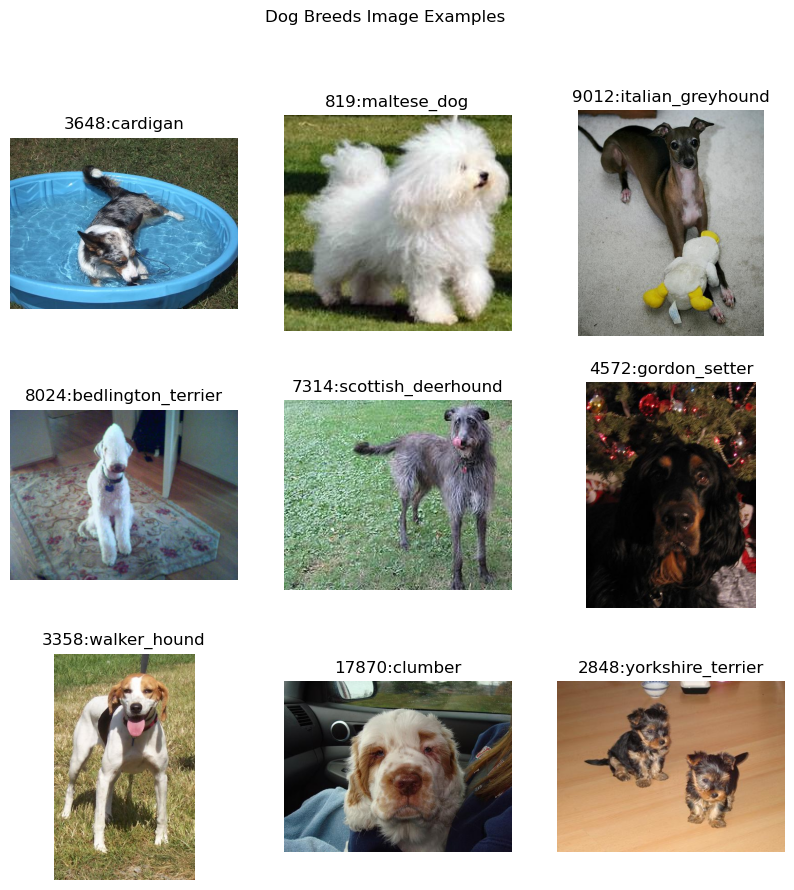

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# get random dog image indexes for plotting
random_idxs = random.sample(range(len(labels)), 9)

# plot random dog image in 3 by 3 grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
fig.suptitle('Dog Breeds Image Examples')

for idx,ax in zip(random_idxs, axs.flat):
    image = raw_datasets[idx]['image']
    label_id = raw_datasets[idx]['labels']
    label = ID2LABEL[label_id]
    ax.axis('off')
    ax.set_title(f"{idx}:{label}")
    ax.imshow(image)
    images[0]

plt.show()

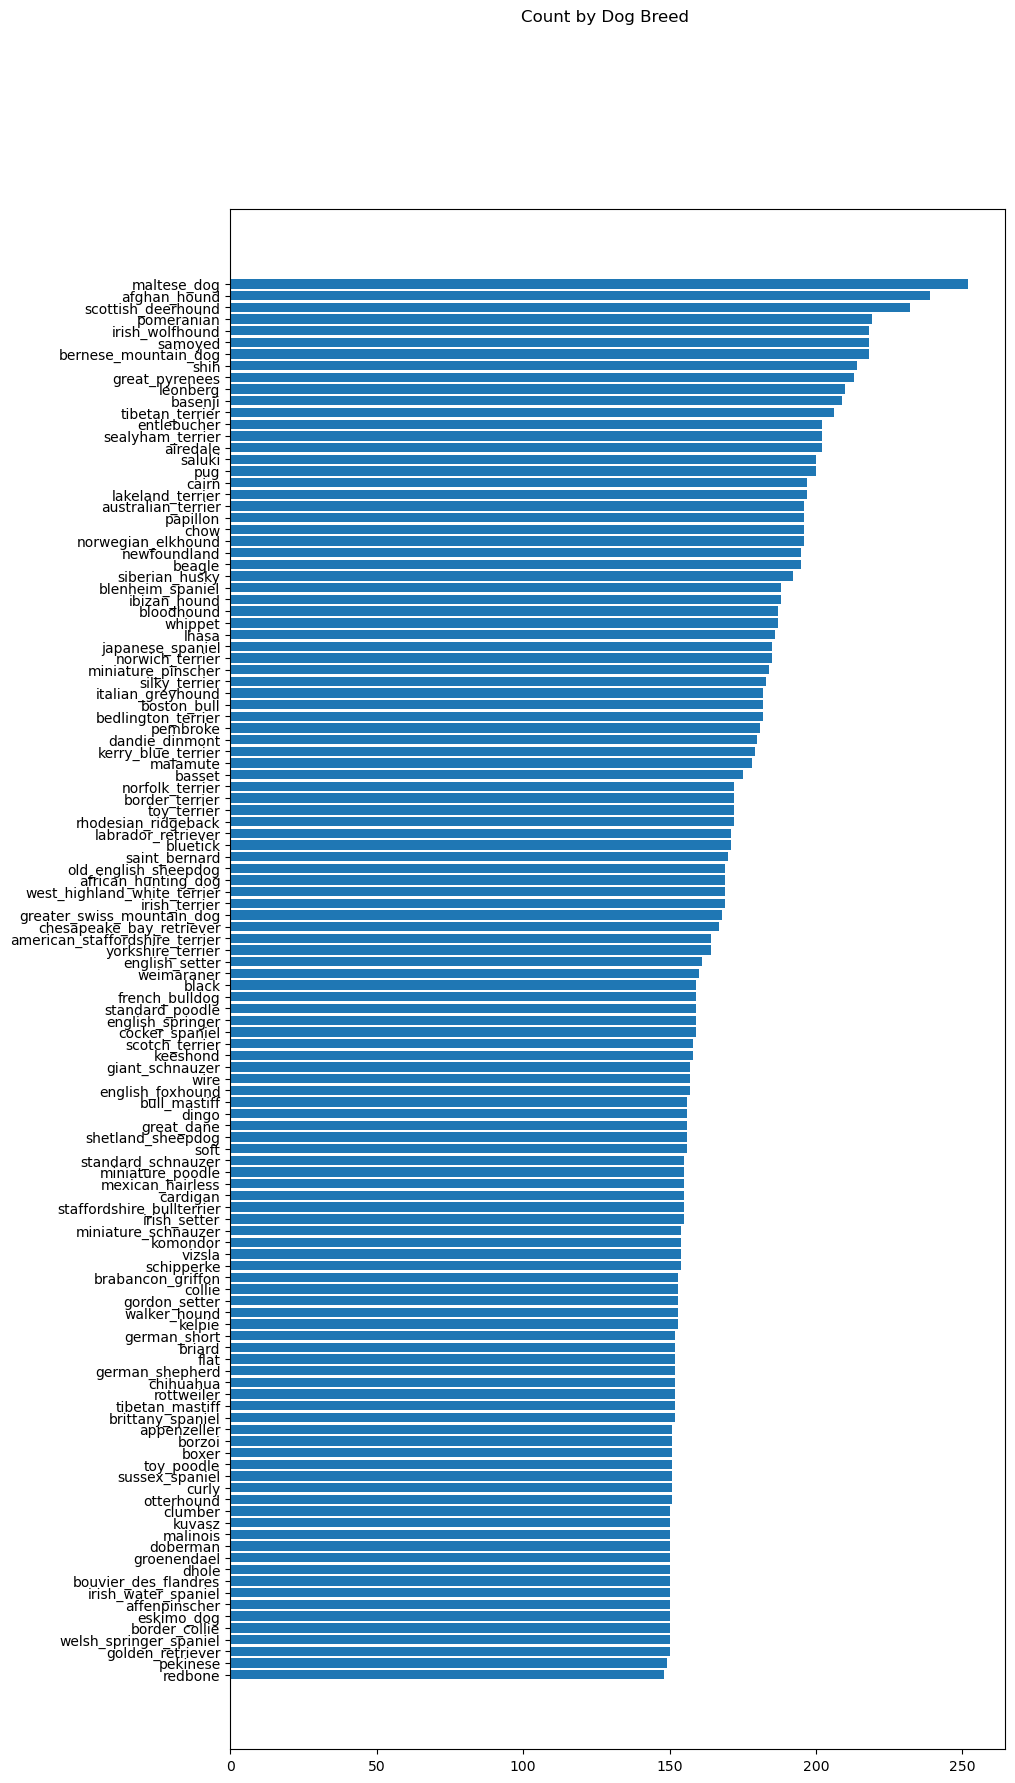

In [7]:
# get label counts sorted by counts in descending order
label_counts = {}
for label in labels:
    label_counts[label] = label_counts.get(label,0)+1
    # sort by count
label_counts = dict(sorted(label_counts.items(), key=lambda kv: kv[1]))

# plot counts by dog breed
# there's around 150-250 images of each dog breed
fig, ax = plt.subplots(figsize=(10,20))
fig.suptitle('Count by Dog Breed')
ax.barh(list(label_counts.keys()), list(label_counts.values()))
plt.show()

# Create Preprocessed Dataset

## Clone Image Processor

In [8]:
from transformers import AutoImageProcessor

# clone image processor from huggingface hub
CHECKPOINT = 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Split Datasets

In [9]:
from datasets import DatasetDict

# split dataset into train-validation-test split (80%-10%-10%)
train_test_datasets = raw_datasets.train_test_split(test_size=0.2, seed=SEED, shuffle=True)
validation_test_datasets = train_test_datasets['test'].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

# create clean dataset with splits
datasets = DatasetDict({
    'train': train_test_datasets['train'],
    'validation': validation_test_datasets['train'],
    'test': validation_test_datasets['test'],
})

datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 16463
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 2058
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2058
    })
})

## Setup On-the-Fly Preprocessing

In [10]:
# we use set_transform to do on-the-fly processing of images to reduce ram usage
def train_transforms(example):
    example.update(image_processor(example['image'], return_tensors='pt'))
    return example

def eval_transforms(example):
    example.update(image_processor(example['image'], return_tensors='pt'))
    return example

datasets['train'].set_transform(train_transforms)
datasets['validation'].set_transform(eval_transforms)
datasets['test'].set_transform(eval_transforms)

# Train Model

In [11]:
from transformers import AutoModelForImageClassification

# let's clone model from huggingface hub
model = AutoModelForImageClassification.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Setup Training Metrics

In [12]:
import numpy as np
import evaluate
from sklearn.metrics import top_k_accuracy_score

# let's setup the training metrics with topk-accuracies and macro f1
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    top3_accuracy = top_k_accuracy_score(labels, logits, k=3)
    top5_accuracy = top_k_accuracy_score(labels, logits, k=5)
    f1 = f1_metric.compute(predictions=preds, references=labels, average='macro')
    return {
        **accuracy,
        'top3_accuracy': top3_accuracy,
        'top5_accuracy': top5_accuracy,
        **f1,
    }

## Setup Collate Function

In [13]:
# we setup a collate function to batch the image and label tensors
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Setup Trainer

In [14]:
from transformers import TrainingArguments, Trainer

# we setup the training configurations
#                        seed: we use this for reproducibility
#                  output_dir: we output the model checkpoints to this directory
#                       optim: we use the updated adamw optimizer
#            num_train_epochs: we train for 3 epochs
# per_device_train_batch_size: increase batch size to speed up training
#  per_device_eval_batch_size: increase batch size to speed up evaluation
#               save_strategy: we save the model on each epoch instead of every 500 steps
#         evaluation_strategy: we evaluate the model on each epoch instead of every 500 steps
#      load_best_model_at_end: load the best model with lowest validation loss
#                   report_to: suppress default reporting to third-party loggers
#       remove_unused_columns: this is set False to allow on-the-fly preprocessing 
training_args = TrainingArguments(
    seed=SEED,
    output_dir='./results',
    optim='adamw_torch',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    report_to='none',
    remove_unused_columns=False,
)

# we setup the trainer with our splitted datasets
# with custom metrics and collate function, and on-the-fly preproccessing
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
    data_collator=collate_fn,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

## Get UnFineTuned Performance

In [15]:
# let's get the unfinetuned performance of the model on the test set as a baseline
trainer.evaluate(datasets['test'])

{'eval_loss': 4.801510334014893,
 'eval_accuracy': 0.0029154518950437317,
 'eval_top3_accuracy': 0.008746355685131196,
 'eval_top5_accuracy': 0.0184645286686103,
 'eval_f1': 0.0032764051115440618,
 'eval_runtime': 31.6859,
 'eval_samples_per_second': 64.95,
 'eval_steps_per_second': 2.051}

We got **0.2% Accuracy (eval_accuracy)**, **0.8% Top3 Accuracy (eval_top3_accuracy)**, **1.8% Top5 Accuracy (eval_top5_accuracy)**, and **0.3% Macro F1 (eval_f1)**. 😕

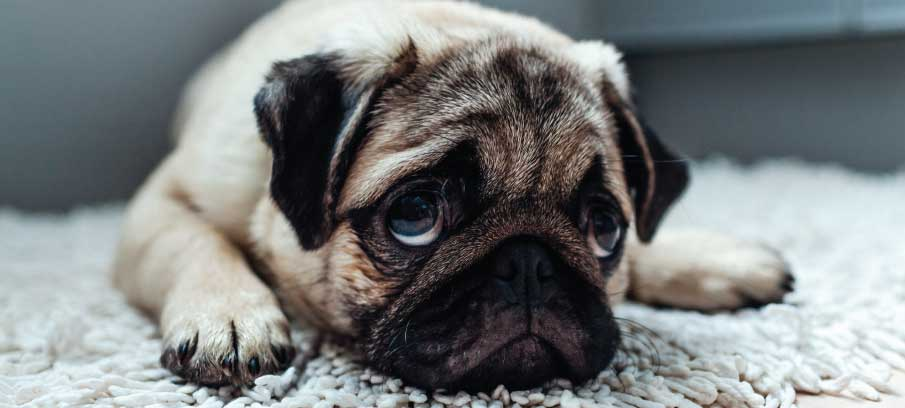

## FineTune Model

Using transfer learning, we can do this! 🦾

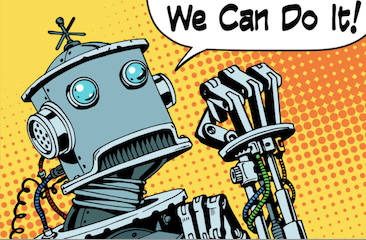

In [16]:
# finetune model
trainer.train()

TrainOutput(global_step=1545, training_loss=2.4975463323994362, metrics={'train_runtime': 1302.3383, 'train_samples_per_second': 37.923, 'train_steps_per_second': 1.186, 'total_flos': 3.8312995639375135e+18, 'train_loss': 2.4975463323994362, 'epoch': 3.0})

## Get FineTuned Performance

In [17]:
# let's get the finetuned performance of the model on the test set
trainer.evaluate(datasets['test'])

{'eval_loss': 1.6841579675674438,
 'eval_accuracy': 0.8401360544217688,
 'eval_top3_accuracy': 0.9718172983479106,
 'eval_top5_accuracy': 0.9873663751214772,
 'eval_f1': 0.8308568211747679,
 'eval_runtime': 27.8356,
 'eval_samples_per_second': 73.934,
 'eval_steps_per_second': 2.335,
 'epoch': 3.0}

**WOAH!** We got **84.0% Accuracy (eval_accuracy)** and **97.1% Top3 Accuracy (eval_top3_accuracy)**, **98.7% Top5 Accuracy (eval_top5_accuracy)**, and **83.0% Macro F1 (eval_f1)**! 🤯

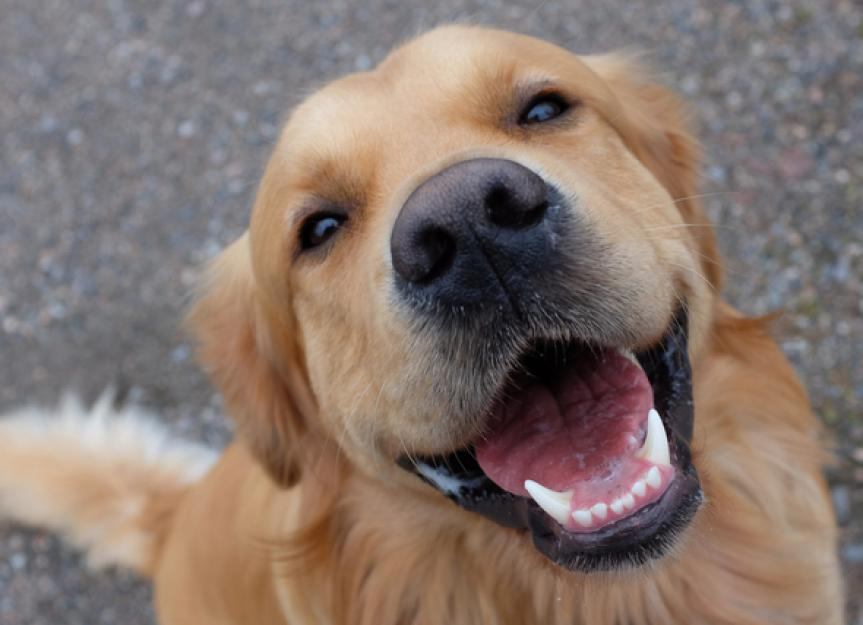

# Let's try some examples!

Let's get some dog image examples from Wikipedia.

In [30]:
import requests
from transformers import pipeline

# let's create a pipeline to classifiy dog images into their respective dog breeds
dog_breeds_multiclass_image_classifier = pipeline("image-classification", model=model.to(torch.device('cpu')), image_processor=image_processor)

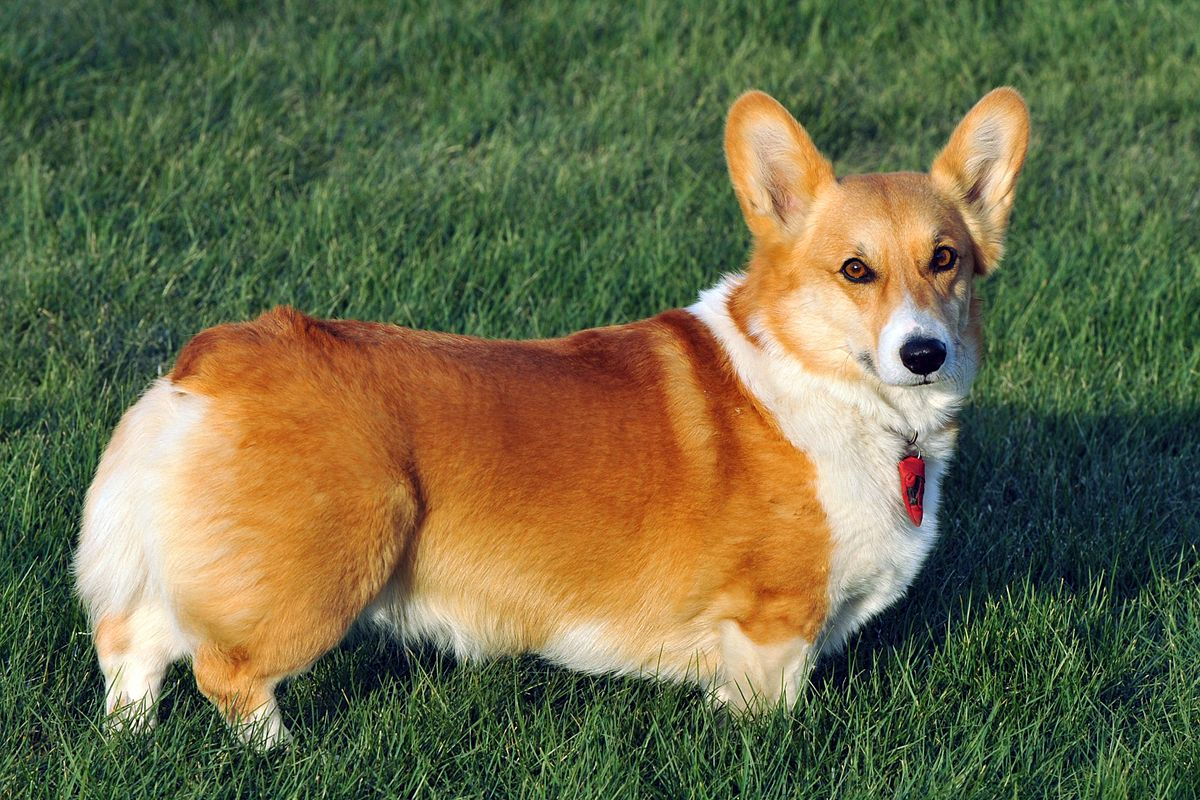

[{'score': 0.28222042322158813, 'label': 'pembroke'},
 {'score': 0.10218419134616852, 'label': 'cardigan'},
 {'score': 0.011134110391139984, 'label': 'shetland_sheepdog'},
 {'score': 0.01032206229865551, 'label': 'dingo'},
 {'score': 0.008734472095966339, 'label': 'beagle'}]

In [31]:
# let's see what it classifies a pembroke corgi
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Welchcorgipembroke.JPG/1200px-Welchcorgipembroke.JPG'
image = PIL.Image.open(requests.get(url, stream=True).raw)
display(image)
dog_breeds_multiclass_image_classifier(image)

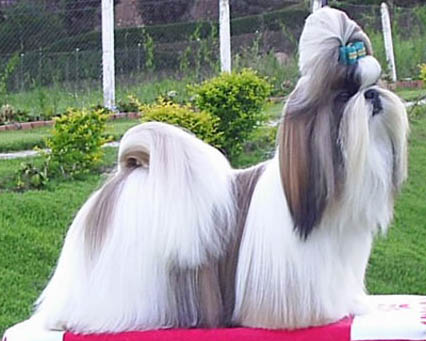

[{'score': 0.1866934448480606, 'label': 'shih'},
 {'score': 0.08710717409849167, 'label': 'lhasa'},
 {'score': 0.045315902680158615, 'label': 'tibetan_terrier'},
 {'score': 0.035105522722005844, 'label': 'japanese_spaniel'},
 {'score': 0.019265059381723404, 'label': 'pekinese'}]

In [32]:
# let's see what it classifies a siberian husky
url = 'https://upload.wikimedia.org/wikipedia/commons/d/df/Shihtzu_%28cropped%29.jpg'
image = PIL.Image.open(requests.get(url, stream=True).raw)
display(image)
dog_breeds_multiclass_image_classifier(image)

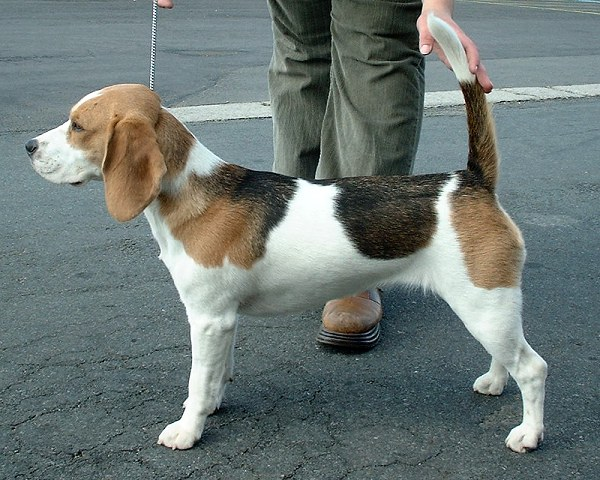

[{'score': 0.17549197375774384, 'label': 'beagle'},
 {'score': 0.1123800277709961, 'label': 'english_foxhound'},
 {'score': 0.09878842532634735, 'label': 'walker_hound'},
 {'score': 0.03525539115071297, 'label': 'basset'},
 {'score': 0.010063127614557743, 'label': 'bluetick'}]

In [33]:
# let's see what it classifies a beagle
url = 'https://upload.wikimedia.org/wikipedia/commons/5/55/Beagle_600.jpg'
image = PIL.Image.open(requests.get(url, stream=True).raw)
display(image)
dog_breeds_multiclass_image_classifier(image)